In [1]:
from importlib import reload
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from tqdm.notebook import tqdm

In [2]:
path = 'data/full_pkls/'

In [17]:
from scipy import stats as sci_stats
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score

from social_phi import get_signal, sliding_window, get_single_signal, experiment_hop_range, phi_for_act_sig


def issues_state_processing(states, timings, lifetimes):
    start_days = np.array([t//(24*3600) for t in timings])
    end_days = (start_days + lifetimes)*(1-states)
    m = min(end_days[end_days > 0].tolist() + start_days.tolist())
    M = max(end_days[end_days > 0].tolist() + start_days.tolist())
    sig = np.zeros(M-m+1)
    for d in end_days:
        if d > 0:
            sig[d-m] += 1
    return sig, M, m


def prepare_signals(data):
    ## closed issues
    closed_issues, max_issue_time, min_issue_time = issues_state_processing(
        states=data['issues_state'], timings=data['opened_issues'], lifetimes=data['issues_lifetime']
    )
    ## stars, forks, opened_issues, closed_issues
    signals = {}
    for k in ['forks', 'stars', 'opened_issues']:
        metric, a, b = get_single_signal(data[k], time_scale=24*3600, binarize=False)
        signals[k] = {
            'sig': metric,
            'm' : b,
            'M' : a
        }
    signals['closed_issues'] = {
        'sig' : closed_issues,
        'm' : min_issue_time,
        'M' : max_issue_time    
    }

    min_act_time = min([min(v) for v in data['activities'].values()]) // (24*3600)
    max_act_time = max([max(v) for v in data['activities'].values()]) // (24*3600)
    m = min([v['m'] for v in signals.values()] + [min_act_time])
    M = max([v['M'] for v in signals.values()] + [max_act_time])

    for k in signals:
        signals[k] = np.pad(signals[k]['sig'], pad_width=(signals[k]['m'] - m, M - signals[k]['M']))
    
    sig = get_signal(data['activities'], time_scale=24*3600, binarize=True)
    signals['activities'] = np.pad(sig, pad_width=(min_act_time - m, M - max_act_time))
    return signals


def prepare_data(file):
    data = pickle.load(open(path + file, 'rb'))
    signals = prepare_signals(data)
    
    ## loading phi stats
    csv_path = 'data/phi_stats/' + file[:-4] + '.csv'
    if os.path.exists(csv_path):
        stats = pd.read_csv(csv_path)
    else:
        stats = experiment_hop_range(sig=signals['activities'], window=30, min_hop=1, max_hop=30, silent=False)
        stats.to_csv(csv_path, index=False)
    
    ## calculating phi for specific tau
    tau = int(stats.hop.values[np.argmax(stats.linear_avg_phi.values)])
    phis, n_users = phi_for_act_sig(signals['activities'], window=30, hop=tau, nan_policy='linear', base=2)
    
    ## other metrics
    metrics = {}
    for k in signals:
        if k != 'activities':
            metrics[k] = sliding_window(signals[k].reshape(1,-1), agg_func=np.sum, window=30, hop=tau)[0]
    metrics['num_activities'] = sliding_window(signals['activities'].sum(axis=0).reshape(1,-1), agg_func=np.sum, window=30, hop=tau)[0]
    metrics['num_active_users'] = n_users
    
    ## put everythin in a data frame
    df = pd.DataFrame(columns=[
            'phi', 'num_activities', 'num_active_users', 'forks', 'opened_issues', 'stars', 'closed_issues'
    ])
    df['phi'] = phis
    for k in metrics:
        df[k] = metrics[k]
    df.to_csv('data/full_csvs/' + file[:-4] + '.csv', index=False)
    return df

def analyze(df):
    ## correlations
    corrs = df.corr(method='pearson') # spearman , kendall
    corr_tvals = corrs * np.sqrt(df.shape[0] - 2) / np.sqrt(1 - corrs**2)
    corr_pvals = sci_stats.t.sf(np.abs(corr_tvals), df.shape[0] - 2)*2
    corr_pvals = pd.DataFrame(corr_pvals, columns=df.columns, index=df.columns)

    mis = np.zeros(shape=[df.shape[1], df.shape[1]])
    for i, col1 in enumerate(df.columns):
        for j,col2 in enumerate(df.columns):
            mis[i,j] = normalized_mutual_info_score(df[col1], df[col2])
    mis = pd.DataFrame(mis, columns=df.columns, index=df.columns)
    
    return corrs, corr_pvals, mis

In [28]:
# check_existance = lambda file : os.path.exists(f'data/full_csvs/{file[:-4]}.csv')

# for file in tqdm(os.listdir(path)):
#     if check_existance(file):
#         continue
#     print(file)
#     prepare_data(file)

In [62]:
csv_path = 'data/full_csvs/'
corrs = []
mis = []
columns = None
for csv in os.listdir(csv_path):
    corr, pvalue, mi = analyze(pd.read_csv(csv_path + csv))
    corrs += [corr.drop(['phi'], axis=1).loc['phi'].values * (pvalue.drop(['phi'], axis=1).loc['phi'] < 0.05).astype(float)]
    mis += [mi.drop(['phi'], axis=1).loc['phi'].values]
corrs = np.array(corrs)
mis = np.array(mis)
corrs.shape, mis.shape

((14, 6), (14, 6))

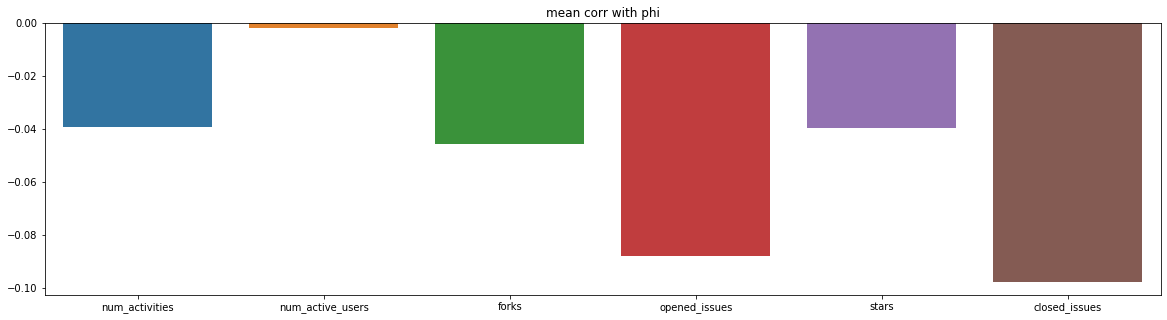

In [63]:
plt.figure(figsize=(20,5))
plt.title('mean corr with phi')
sns.barplot(x=corr.drop(['phi'], axis=1).columns, y=corrs.mean(axis=0))
plt.show()

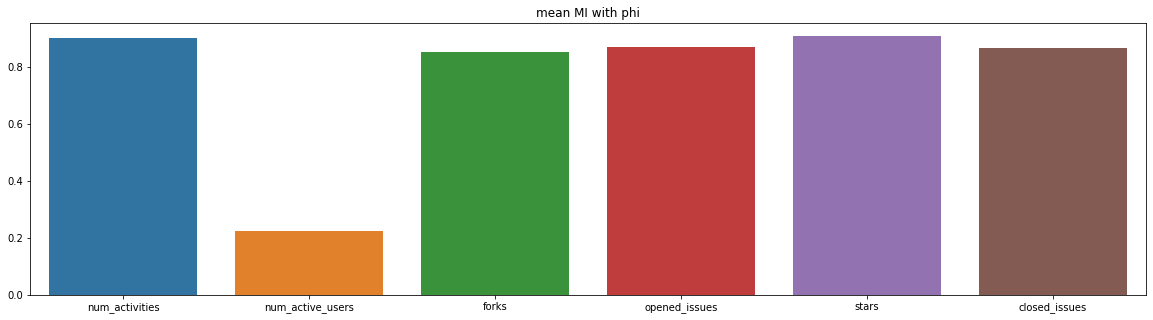

In [61]:
plt.figure(figsize=(20,5))
plt.title('mean MI with phi')
sns.barplot(x=corr.drop(['phi'], axis=1).columns, y=mis.mean(axis=0))